In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_samples, silhouette_score

from utils.utility_functions import categorical_cmap

In [2]:
out = os.path.join(os.getcwd(), 'output/silhouette_hdbscan')
if not os.path.exists(out):
    os.makedirs(out)

data = pd.read_parquet(
    os.path.join(os.getcwd(), 'input/CRC-097_clean_cylinter_clustering_3d_hdbscan.parquet')
)
data = data[data['cluster'] != -1]
silho_input = data[['emb1', 'emb2', 'emb3', 'cluster']]

# Subsample clustered data for silhouette analysis
silho_subset = silho_input.sample(n=50000)

cmap = categorical_cmap(
    numUniqueSamples=len(silho_input['cluster'].unique()),
    numCatagories=10, cmap='tab10', continuous=False
)

cluster_centers = pd.DataFrame(
    index=sorted(silho_subset['cluster'].unique())
)

embed_cols = [i for i in silho_subset.columns if 'emb' in i]
for clus in sorted(silho_subset['cluster'].unique()):
    group = silho_subset[silho_subset['cluster'] == clus]
    for emb_dim in embed_cols:
        emb_mean = group[emb_dim].mean()
        cluster_centers.loc[clus, emb_dim] = emb_mean

n_clusters = len(cluster_centers.index.unique())

silhouette_spacer = 1000

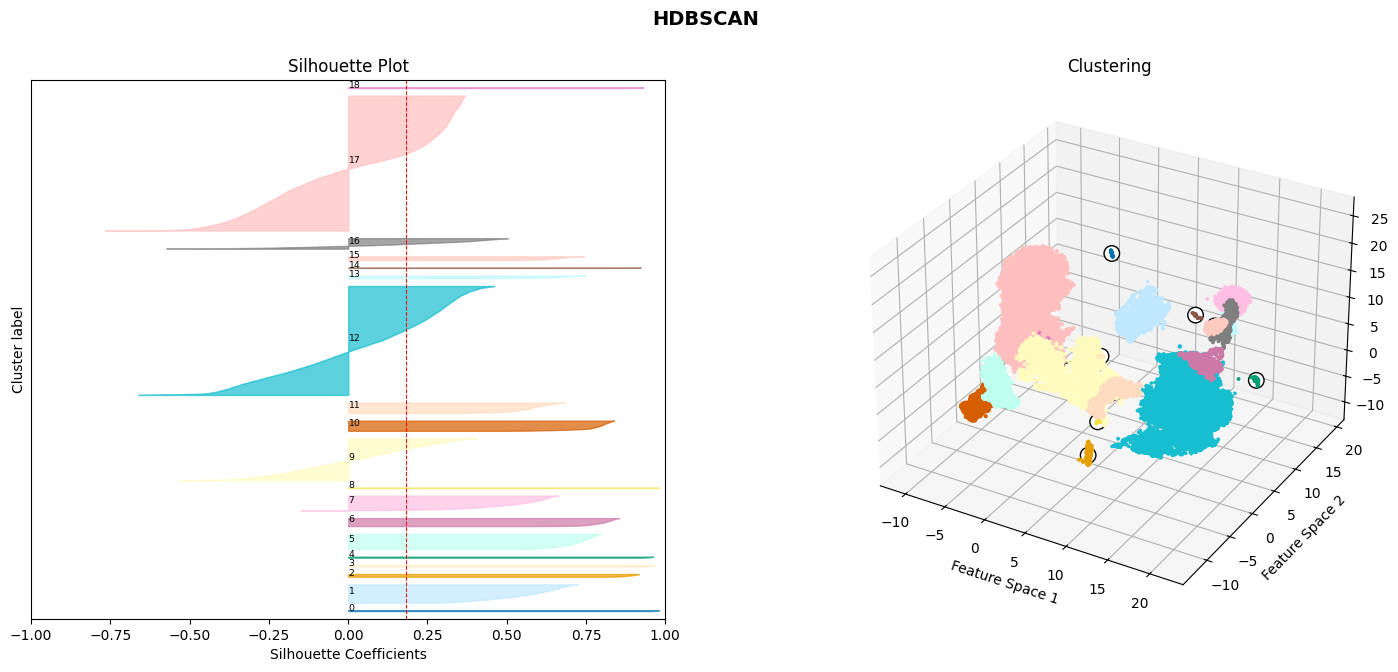

In [3]:
# Plot
fig_silho = plt.figure(figsize=(18, 7))
gs = plt.GridSpec(1, 2, figure=fig_silho)
ax1_silho = fig_silho.add_subplot(gs[0, 0], projection=None)
ax2_silho = fig_silho.add_subplot(gs[0, 1], projection='3d')

ax1_silho.set_xlim([-1, 1])

ax1_silho.set_ylim([0, len(silho_subset) + (n_clusters + 1) * silhouette_spacer])

sample_silhouette_values = silhouette_samples(silho_subset[embed_cols], silho_subset['cluster'])

y_lower = silhouette_spacer
for i in cluster_centers.index.unique():

    ith_cluster_silhouette_values = (sample_silhouette_values[silho_subset['cluster'] == i])
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]

    y_upper = y_lower + size_cluster_i

    color = cmap.colors[i]

    ax1_silho.fill_betweenx(
        np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
        facecolor=color, edgecolor=color, alpha=0.7
    )

    ax1_silho.text(
        0.0, y_lower + 0.5 * size_cluster_i, str(i),
        fontdict={'size': 20 / np.log(n_clusters)}
    )

    # compute the new y_lower for next plot
    y_lower = y_upper + silhouette_spacer

silhouette_avg = silhouette_score(silho_subset[embed_cols], silho_subset['cluster'])

ax1_silho.set_title('Silhouette Plot')
ax1_silho.set_xlabel('Silhouette Coefficients')
ax1_silho.set_ylabel('Cluster label')

ax1_silho.axvline(x=silhouette_avg, color='r', lw=0.75, linestyle='--')

ax1_silho.set_yticks([])

ax2_silho.scatter(
    silho_subset['emb1'], silho_subset['emb2'], silho_subset['emb3'],
    marker='.', s=30, edgecolor='k', lw=0, alpha=1.0,
    c=[cmap.colors[i] for i in silho_subset['cluster']]
)

ax2_silho.scatter(
    cluster_centers['emb1'], cluster_centers['emb2'], cluster_centers['emb3'],
    marker='o', c='white', alpha=1, s=125, edgecolor='k'
)

for i in cluster_centers.iterrows():
    ax2_silho.scatter(
        i[1]['emb1'], i[1]['emb2'], i[1]['emb3'],
        marker='$%d$' % i[0], zorder=100, alpha=1, s=40,
        edgecolor='k'
    )

ax2_silho.set_title('Clustering')
ax2_silho.set_xlabel('Feature Space 1')
ax2_silho.set_ylabel('Feature Space 2')

total_clusters = len(silho_input['cluster'].unique())

fig_silho.suptitle('HDBSCAN', fontsize=14, fontweight='bold')

plt.savefig(os.path.join(out, 'silhouette_hdbscan.pdf'), bbox_inches='tight')
plt.show()
plt.close('all')